
# Computer Vision WS-24/25 Assignment 2.4: Feature Extraction and Matching

## Part 0.1: Setting Up the Environment
Before we start feature extraction and matching, we need to setup our working environment. This includes a few lines of code to setup the jupyter environment and to verify our python environment. We include all the static python libraries that we will use during this assignment. If you feel like importing additional libraries for visualization or debugging purposes, please feel free to add them here!

In [103]:
%load_ext autoreload
%autoreload 3

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [104]:
import cv2
import numpy as np 
import matplotlib.pyplot as plt

## Part 0.2: Load images
The task of this assignment is to extract features for both images using cv2 feature extractors and establish the matches between two images. We provide two images in the `data` folder. 

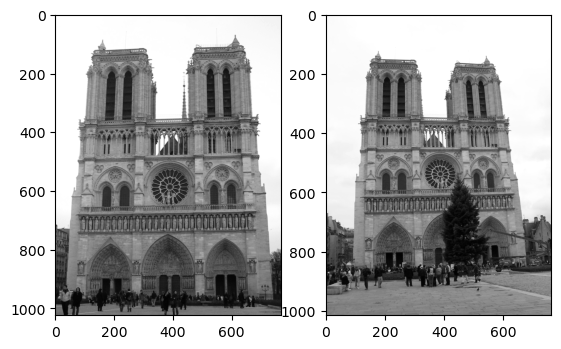

In [105]:
img1 = cv2.imread("./data/NotreDame1.jpg")
color1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
gray1 = cv2.cvtColor(color1, cv2.COLOR_RGB2GRAY)

img2 = cv2.imread("./data/NotreDame2.jpg")
color2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
gray2 = cv2.cvtColor(color2, cv2.COLOR_RGB2GRAY)

plt.subplot(1, 2, 1)
plt.imshow(gray1, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(gray2, cmap='gray')
plt.show()

## Part 1: Keypoints Detection

### Part 1.0: Use SIFT as the keypoint detector (0.5pt)
First, let's try the Scale Invariant Feature Transform (SIFT) algorithm from cv2. In the cell below, we define a variable `sift_kp` for the detected keypoints using the SIFT method. What you need to do is to complete the code inside the comment block to get the `sift_kp` value.

In [106]:
"# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****"
sift = cv2.SIFT_create()

sift_kp = sift.detect(gray1,None)
"# *****End OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****"

print("Number of SIFT keypoints: ", len(sift_kp))

Number of SIFT keypoints:  6236


### Part 1.1: Visualize Keypoints (0.5pt)
Next, let's visualize the keypoints. Please implement the function `visualize_keypoint()`. 
Note: preprocess the keypoints from the cv2 `keypoint` data structure to the numpy arrays storing coordinates of keypoints using function `convert_kp_to_coord()`. Here is the example for the SIFT keypoints:

![example](./data/example_sift_kp.png)

In [ ]:
def visualize_keypoint(keypoints, image):
    """
    Visualize keypoints on the image.


    Inputs:
    - keypoints: np.array(N, 2), the coordinates of keypoints, [col, row]
    - image: grayscale image or color image
   
    """

    "# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****"
    if len(image.shape) == 2:
        rgb_image = image.copy()
        rgb_image = rgb_image[..., None].repeat(3, -1)

    plt.imshow(rgb_image)
    fig = plt.gcf()
    ax = fig.gca()
    for kp in keypoints:
        ax.add_patch(plt.Circle(kp, 0.2, color="r"))

    plt.imshow(rgb_image)
    plt.axis("off")
    plt.show()
    "# *****End OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****"

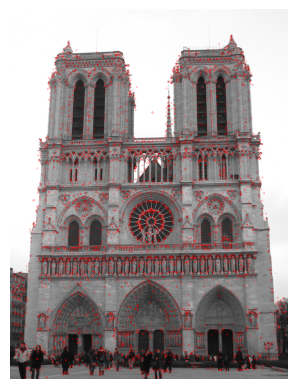

In [108]:
def convert_kp_to_coord(keypoints):
    coord_list = []
    for kp in keypoints:
        coord_list.append(kp.pt)

    return np.array(coord_list)


sift_kp_coord = convert_kp_to_coord(sift_kp)
visualize_keypoint(sift_kp_coord, gray1)

### Part 1.2: Use FAST as keypoint detector (0.5pt)
Please use the Features from Acelerated Segment Test (FAST) algorithm from cv2 to detect keypoints and visualize the keypoints

Number of ORB keypoints:  500


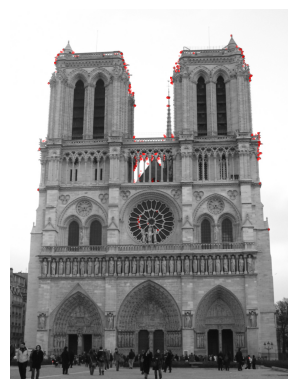

In [109]:
"# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****"
orb = cv2.ORB_create()
orb_kp = orb.detect(gray1, None)
"# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****"

print("Number of ORB keypoints: ", len(orb_kp))
orb_kp_coord = convert_kp_to_coord(orb_kp)
visualize_keypoint(orb_kp_coord, gray1)

### Part 1.3: Use Harris Corner as the keypoint detector (0.5pt)
Please use the Harris Corner Detection algorithm from cv2 to detect keypoints and visualize them. The functions returns the Image the Harris detector (score). Then, you need to apply threshold to the score to get a corner mask. To get better corners in the image, we need to try different threshold and choose a suitable value. 

Number of Harris keypoints:  7158


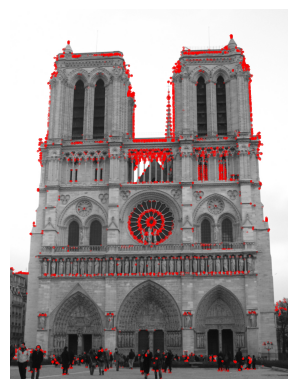

In [110]:
threshold = None
"# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****"
dst = cv2.cornerHarris(gray1, 2, 3, 0.04)
threshold = 0.01 * dst.max()
harris_kp_coord = np.stack((dst > threshold).nonzero(), axis=1)
# swap x,y coordinate, since the harris corner detection return x coordinate in width, y coordinate in height
harris_kp_coord = harris_kp_coord[:,[1,0]]
"# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****"

print("Number of Harris keypoints: ", len(harris_kp_coord))

visualize_keypoint(harris_kp_coord, gray1)

# Part 2: Compute descriptors (0.5pt)
After detecting keypoints, we can compute the descriptors. In this part, we use HOG and rBREIF to compute the descriptors for detected SIFT and ORB keypoints. Let's first compute the descriptors for the first image.

In [ ]:
"# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****"

_, hog_des1 = sift.compute(gray1, sift_kp)
_, breif_des1 = orb.compute(gray1, orb_kp)

"# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****"

print("SIFT descriptor shape: ", hog_des1.shape)
print("ORB descriptor shape: ", breif_des1.shape)

SIFT descriptor shape:  (6236, 128)
ORB descriptor shape:  (500, 32)


Now, we apply the SIFT and ORB to detect keypoints and extract features to the second image.

In [112]:
"# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****"

sift_kp2 = sift.detect(gray2,None)
sift_kp_coord2 = convert_kp_to_coord(sift_kp2)
_, hog_des2 = sift.compute(gray2, sift_kp2)

orb_kp2 = orb.detect(gray2, None)
orb_kp_coord2 = convert_kp_to_coord(orb_kp2)
_, breif_des2 = orb.compute(gray2, orb_kp2)

"# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****"

print("SIFT descriptor shape: ", hog_des2.shape)
print("ORB descriptor shape: ", breif_des2.shape)

SIFT descriptor shape:  (5115, 128)
ORB descriptor shape:  (500, 32)


## Part 3: Descriptor Matching

### Part 3.0:Brute-force descriptor matcher with Lowe tests and cross consistency check (3pt)
In this part, we can implement brute-force matchers, which takes the descriptor of one feature in first set and is matched with all other features in second set using some distance calculation. Additionally, we consider to use cycle consistency check and lowe tests to get better results.  Please implement the `compute_distance_matrix()`, `cycle_consistency_match()`, `lowe_match` in `matcher.py` file.
Note: when computing the distance matrix, you should choose a correct distance measurement based on the descriptor data dtype. For example, norm `L2` is good for HOG features. For binary string based descriptors like ORB, norm `hamming` should be used.


In [118]:
from matcher import cycle_consistency_match, lowe_match

# change the threshold and ratio to get better matches
threshold = 270
ratio = 0.5

print("Start Matching SIFT Features:")
hog_matches1 = cycle_consistency_match(descriptors1=hog_des1, descriptors2=hog_des2)
hog_matches2 = lowe_match(
    descriptors1=hog_des1, descriptors2=hog_des2, threshold=threshold, ratio=ratio
)
print("Number of matches (cycle consistency): ", len(hog_matches1))
print("Number of matches (lowe ratio test): ", len(hog_matches2))

Start Matching SIFT Features:
Number of matches (cycle consistency):  2170
Number of matches (lowe ratio test):  299


In [119]:
threshold = 50
ratio = 0.8


print("Start Matching ORB Features")
orb_matches1 = cycle_consistency_match(
    descriptors1=breif_des1, descriptors2=breif_des2, norm="hamming"
)
orb_matches2 = lowe_match(
    descriptors1=breif_des1,
    descriptors2=breif_des2,
    threshold=threshold,
    ratio=ratio,
    norm="hamming",
)
print("Number of matches (cycle consistency): ", len(orb_matches1))
print("Number of matches (lowe ratio test): ", len(orb_matches2))

Start Matching ORB Features
Number of matches (cycle consistency):  146
Number of matches (lowe ratio test):  28


### Part 3.1: Visualize Matches (0.5pt)
After we get the matching between two images, we can visualize it to check the performance of two feature extractors. To do so, we need to implement the  `plot_matches` function in the cell below. Here is the example for the output:

![example](./data/example_sift_match.png)

In [ ]:
def plot_matches(kp1, kp2, matches, image1, image2):
    new_shape1 = list(image1.shape)
    new_shape2 = list(image2.shape)

    if image1.shape[0] < image2.shape[0]:
        new_shape1[0] = image2.shape[0]
    elif image1.shape[0] > image2.shape[0]:
        new_shape2[0] = image1.shape[0]

    if image1.shape[1] < image2.shape[1]:
        new_shape1[1] = image2.shape[1]
    elif image1.shape[1] > image2.shape[1]:
        new_shape2[1] = image1.shape[1]

    if new_shape1 != image1.shape:
        new_image1 = np.zeros(new_shape1, dtype=image1.dtype)
        new_image1[: image1.shape[0], : image1.shape[1]] = image1
        image1 = new_image1

    if new_shape2 != image2.shape:
        new_image2 = np.zeros(new_shape2, dtype=image2.dtype)
        new_image2[: image2.shape[0], : image2.shape[1]] = image2
        image2 = new_image2

    offset = np.array(image1.shape)
    # align image horizontal
    image = np.concatenate([image1, image2], axis=1)
    offset[0] = 0

    fig, ax = plt.subplots()
    ax.imshow(image, cmap="gray")
    ax.axis((0, image1.shape[1] + offset[1], image2.shape[0] + offset[0], 0))

    # Hint: use rng.random(3) can generate random colors to visualize matches
    rng = np.random.default_rng()

    "# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****"


    for i in range(matches.shape[0]):
        idx0 = matches[i, 0]
        idx1 = matches[i, 1]

        color = rng.random(3)

        ax.plot(
            (kp1[idx0, 1], kp2[idx1, 1] + offset[1]),
            (kp1[idx0, 0], kp2[idx1, 0] + offset[0]),
            "-",
            color=color,
        )

    "# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****"

    plt.show()



Here, we visualize the top-10 matches.

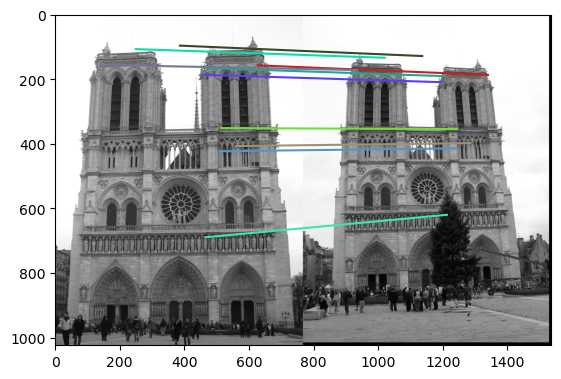

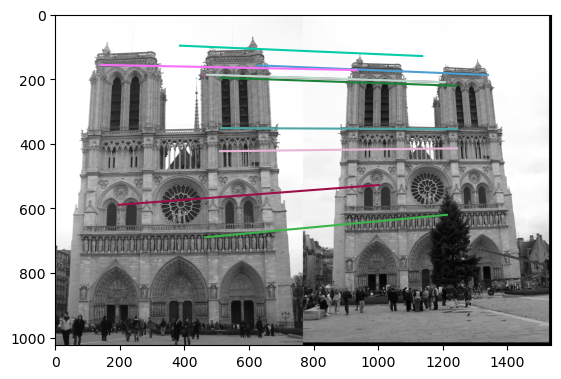

In [121]:
plot_matches(sift_kp_coord, sift_kp_coord2, hog_matches1[:10], gray1, gray2)
plot_matches(sift_kp_coord, sift_kp_coord2, hog_matches2[:10], gray1, gray2)

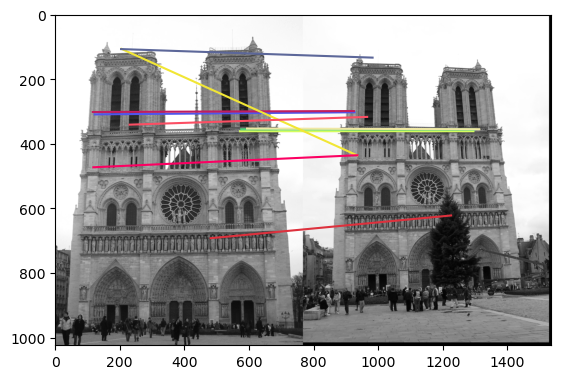

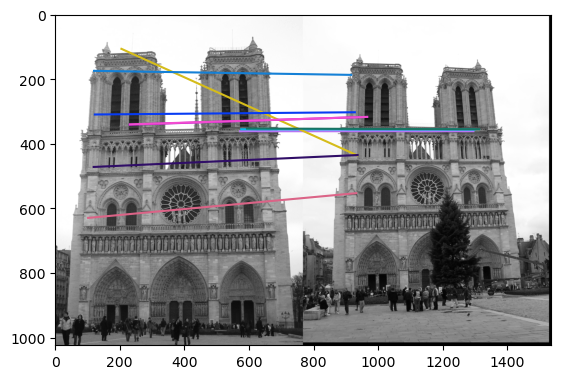

In [122]:
plot_matches(orb_kp_coord, orb_kp_coord2, orb_matches1[:10], gray1, gray2)
plot_matches(orb_kp_coord, orb_kp_coord2, orb_matches2[:10], gray1, gray2)